In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
normalizeUL2(u,M) = u.*sign.(sum(u))./ sqrt(u'*M*u);

In [3]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack 
using Plots
using OrdinaryDiffEq

In [4]:
# Parameters
grid_resolution        = 300
quadrature_order       = 5
nev                    = 10        # which Eigenvector to choose
ϵ                      = 0.2       # perturbation
t₀                      = 0.6      # parameter value corresponding to ϵ=0
solver_tolerance       = 1e-9
solver                 = OrdinaryDiffEq.BS5();

In [5]:
rot_double_gyre = @velo_from_stream Ψ_rot_dgyre begin
    st          = heaviside(t)*heaviside(1-t)*t^2*(3-2*t) + heaviside(t-1)
    heaviside(x)= 0.5*(sign(x) + 1)
    Ψ_P         = sin(2π*x)*sin(π*y)
    Ψ_F         = sin(π*x)*sin(2π*y)
    Ψ_rot_dgyre = (1-st) * Ψ_P + st * Ψ_F
end
T(x,p) = flow(rot_double_gyre, x, [0.0, t₀ + p],
    tolerance = solver_tolerance, solver = solver)[end];

In [6]:
LL, UR = (0.0, 0.0), (1.0, 1.0)
ctx, _ = regularTriangularGrid((grid_resolution, grid_resolution), LL, UR, quadrature_order = quadrature_order);

In [7]:
M = assembleMassMatrix(ctx);

In [8]:
# assemble K
DT₀(x) = linearized_flow_autodiff(y -> T(y,0) , x)
A₀(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DT₀(x))))
@time K = assembleStiffnessMatrix(ctx, A₀);

200.828746 seconds (212.71 M allocations: 12.647 GiB, 1.68% gc time)


In [9]:
DTϵ(x) = linearized_flow_autodiff(y -> T(y,ϵ) , x)
Aϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTϵ(x))))
Kϵ = assembleStiffnessMatrix(ctx, Aϵ);

In [15]:
# assemble the linear response matrix L
Adot = x -> linear_response_tensor(T, x, 0)
@time L = assembleStiffnessMatrix(ctx, Adot);

964.789468 seconds (301.72 M allocations: 29.418 GiB, 0.37% gc time)


In [10]:
# solve the linear system
@time λ₀, u₀ = eigs(K, M, which=:SM, nev=nev)
@assert all(imag.(u₀) .== 0)
@assert all(imag.(λ₀) .== 0)
u₀ = real.(u₀)
λ₀ = real.(λ₀)
for i in 1:size(u₀)[2]
    u₀[:,i] = normalizeUL2(u₀[:,i],M)
end

  4.739862 seconds (9.42 M allocations: 886.066 MiB, 3.32% gc time)


In [11]:
# calculate the exact uϵ
λϵ, uϵ = eigs(Kϵ, M, which=:SM, nev=nev)
@assert all(imag.(uϵ) .== 0)
@assert all(imag.(λϵ) .== 0)
uϵ = real.(uϵ)
λϵ = real.(λϵ)
for i in 1:size(uϵ)[2]
    uϵ[:,i] = normalizeUL2(uϵ[:,i],M)
end

In [16]:
# solve the system for the derivative u_dot
u_dot = zero(u₀)
λ_dot = zero(λ₀)
for i in 1:size(u₀)[2] 
    @time u_dot[:,i], λ_dot[i] = getLinearResponse(u₀[:,i],λ₀[i],M,K,L)
end

  2.867663 seconds (4.35 M allocations: 548.977 MiB, 1.86% gc time)
  1.637740 seconds (65.92 k allocations: 341.436 MiB, 1.17% gc time)
  1.624305 seconds (299 allocations: 337.803 MiB, 0.79% gc time)
  1.625509 seconds (299 allocations: 337.803 MiB, 0.59% gc time)
  1.630373 seconds (301 allocations: 337.803 MiB, 0.83% gc time)
  1.618082 seconds (297 allocations: 337.803 MiB, 0.57% gc time)
  1.627997 seconds (299 allocations: 337.803 MiB, 0.48% gc time)
  1.617891 seconds (299 allocations: 337.803 MiB, 0.67% gc time)
  1.621729 seconds (299 allocations: 337.803 MiB, 0.48% gc time)
  1.617138 seconds (299 allocations: 337.803 MiB, 0.50% gc time)


In [17]:
color =    :balance
xticks =   0:1:1
yticks =   0:1:1
colorbar = :left
cmins =     [-2.5, -2.5, -2.5, -2.5, -2.5, -2.5, -2.5, -2.5, -2.5, -2.5, -2.5]
cmaxs =     -cmins
cmins_lr =  [-2.5, -2.5, -2.5, -2.5, -2.5, -2.5, -2.5, -2.5, -2.5, -2.5, -2.5]
cmaxs_lr =  -cmins_lr;

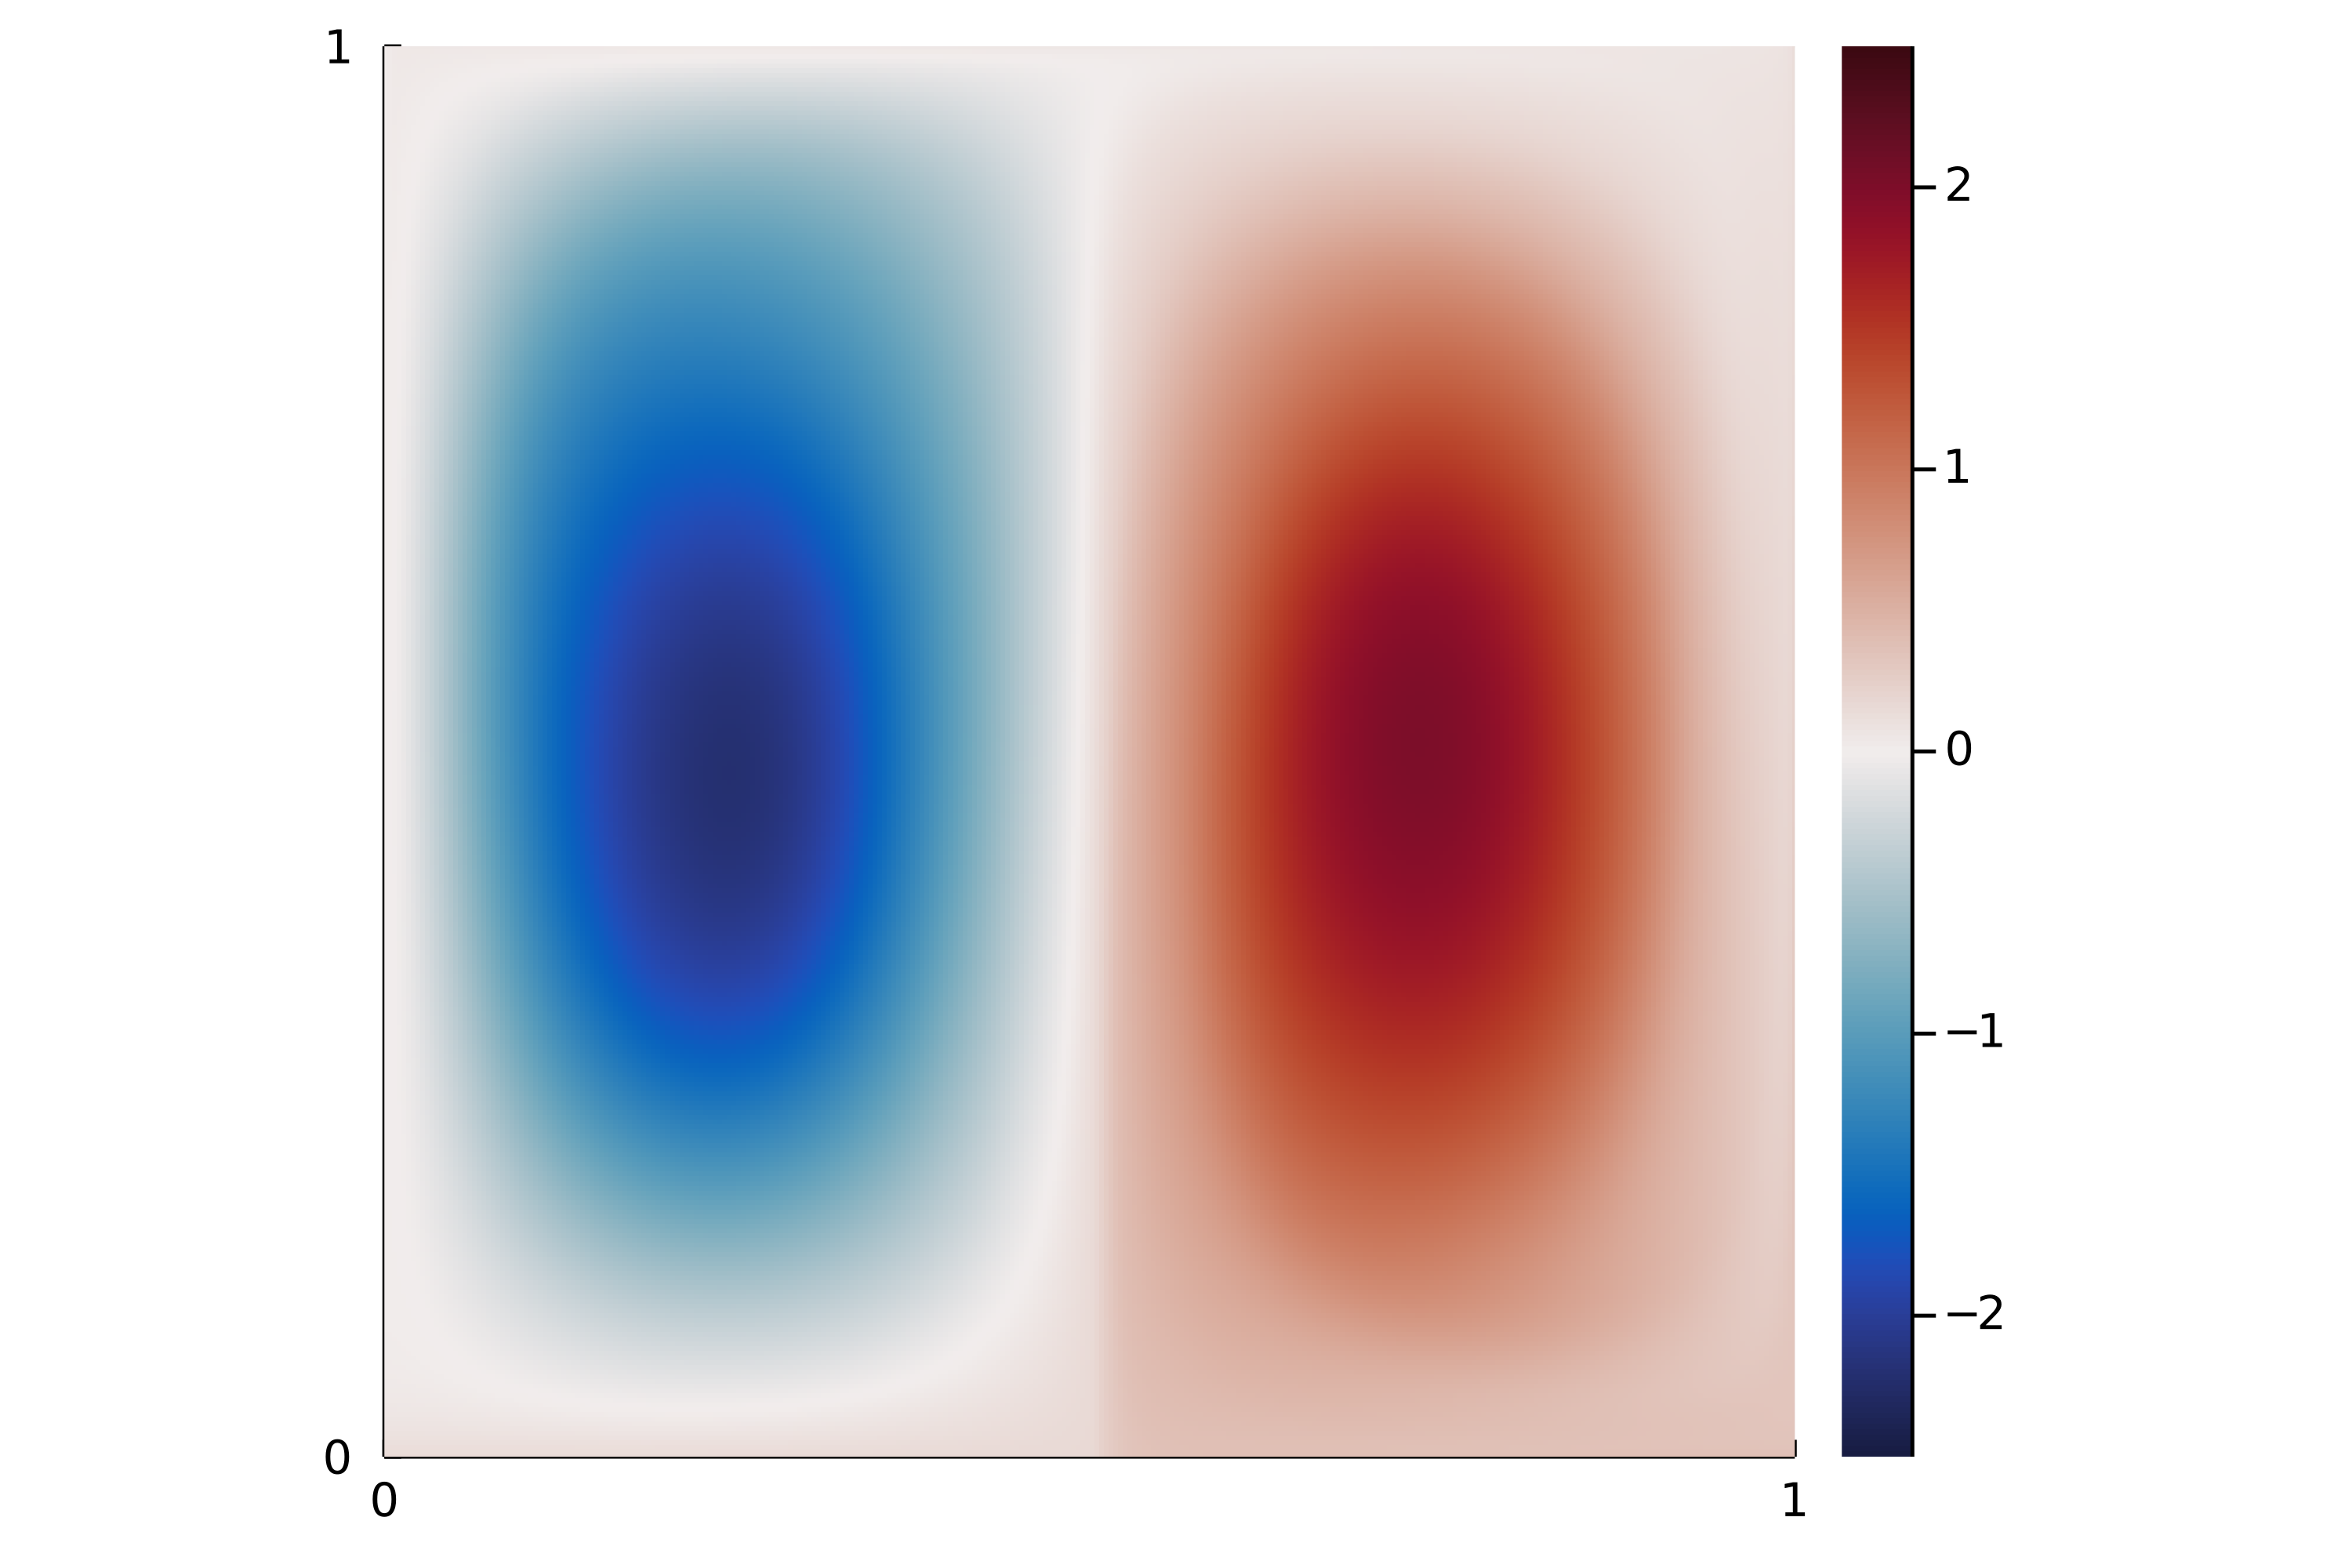

In [26]:
plot_u(ctx, u₀[:,2],  grid_resolution, grid_resolution, 
            title="", 
                colorbar=colorbar, color=color, clims=(cmins[1],cmaxs[1]), xticks=xticks, yticks=yticks)

Plots.plot!(fmt=:png, dpi=500,layout=grid(nev,4))

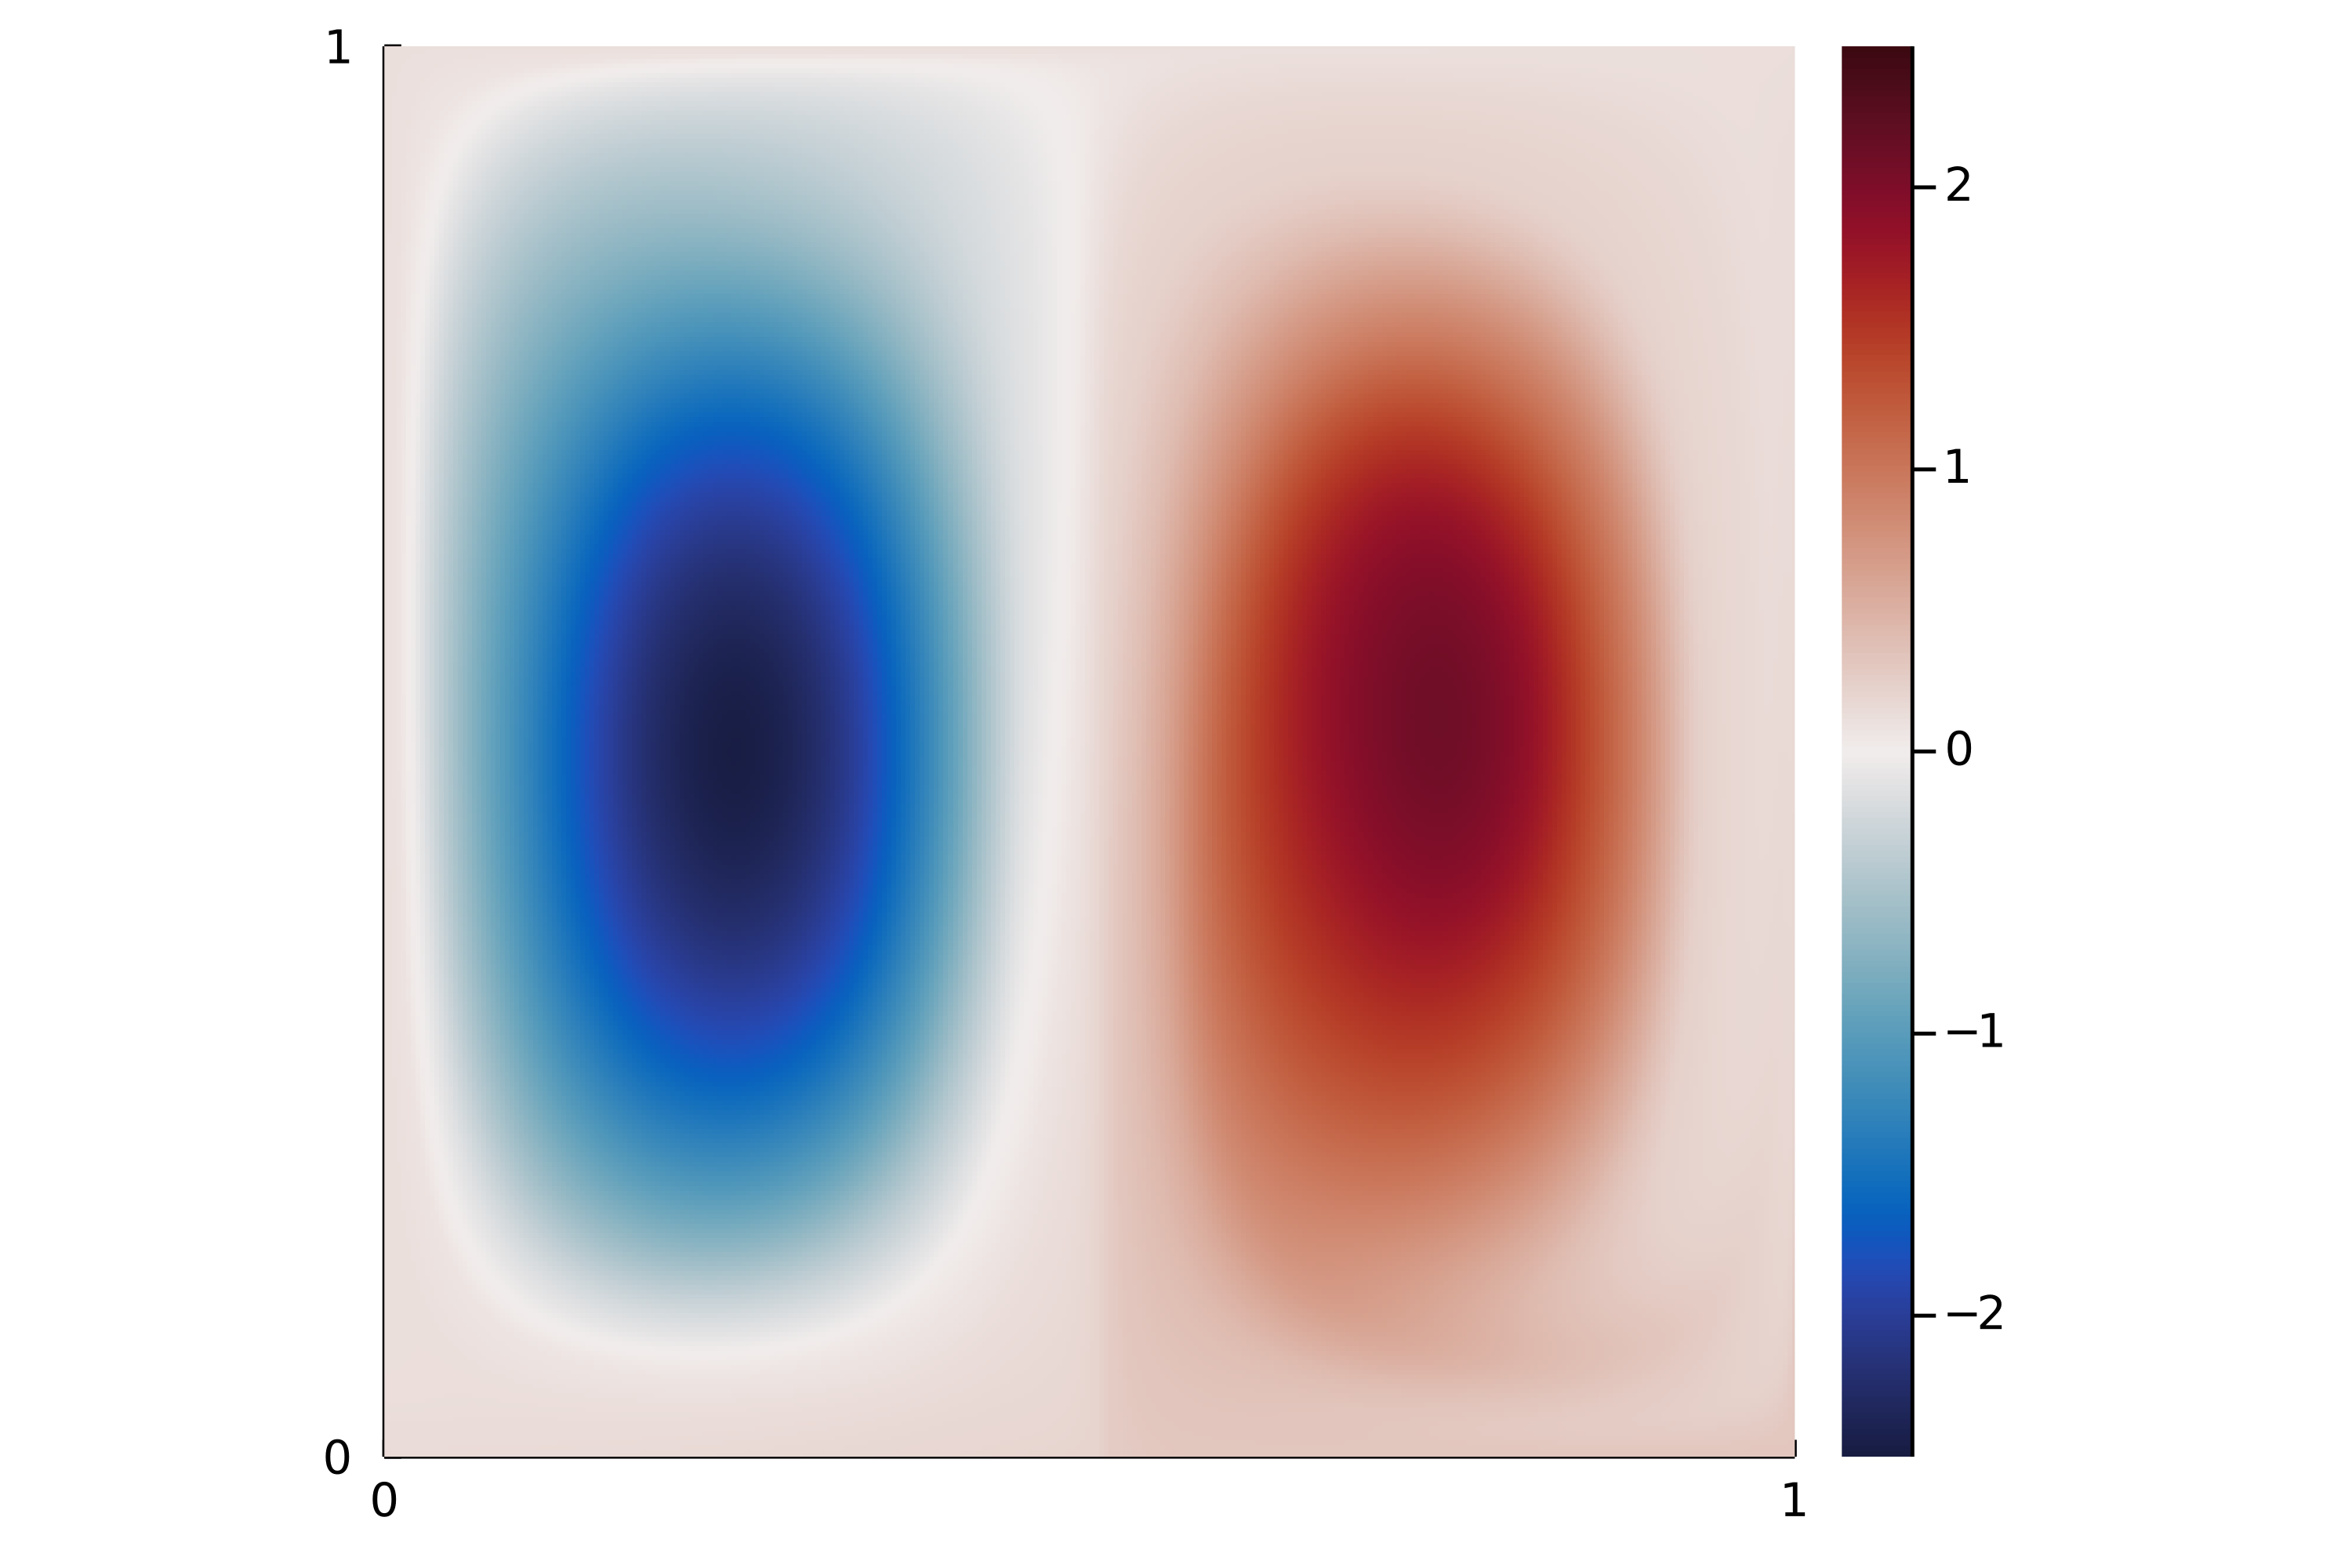

In [27]:
plot_u(ctx, uϵ[:,2],  grid_resolution, grid_resolution, 
            title="", 
                colorbar=colorbar, color=color, clims=(cmins[1],cmaxs[1]), xticks=xticks, yticks=yticks)

Plots.plot!(fmt=:png, dpi=500,layout=grid(nev,4))

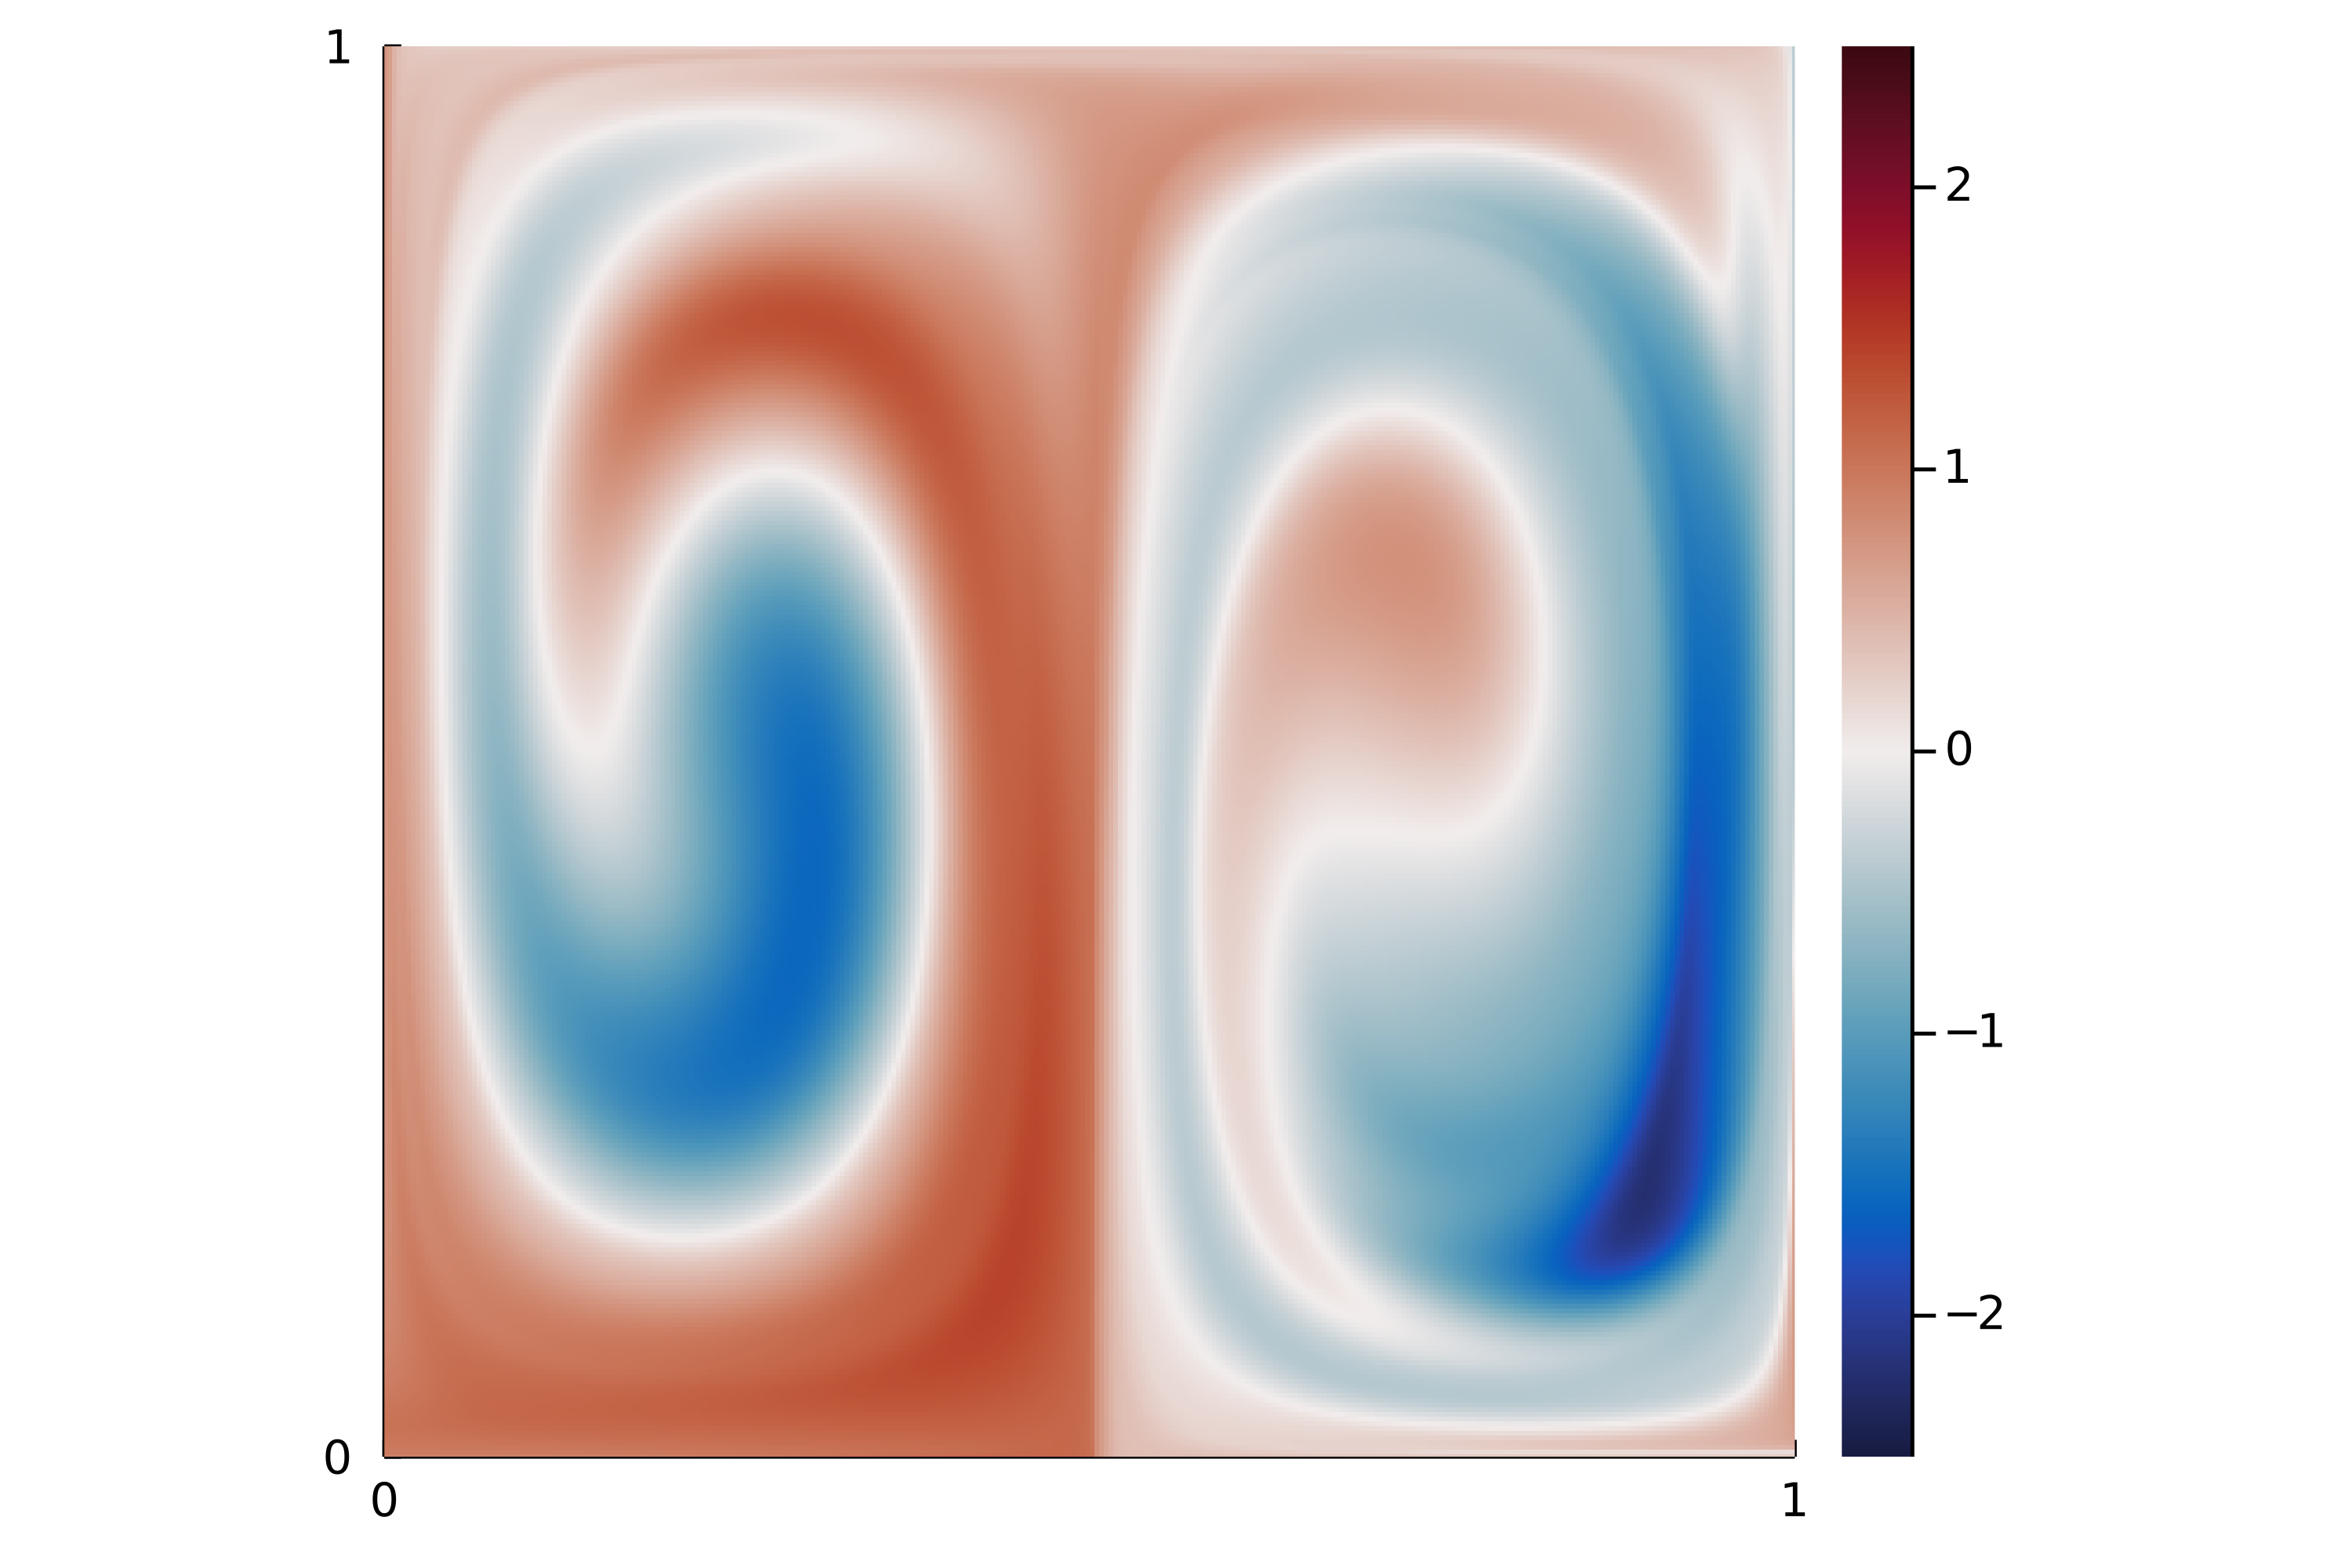

In [28]:
plot_u(ctx, u_dot[:,2],  grid_resolution, grid_resolution, 
            title="", 
                colorbar=colorbar, color=color, clims=(cmins[1],cmaxs[1]), xticks=xticks, yticks=yticks)

Plots.plot!(fmt=:png, dpi=500,layout=grid(nev,4))

In [48]:
λ_dot[2]

-57.970339050982744

In [29]:
using DelimitedFiles

In [31]:
base_path = "D:/Uni/3 Mathematics in Data Science/05 Masterarbeit/Experimente/"
directory = "double_gyre_param_plots_cg/"
filename = "gyre_eigenvalues_n=300_tol=1.0e-9_qo=5_solver=BS5(true)_method=CG.csv";

In [32]:
file = readdlm(base_path*directory*filename, ',', Float64, '\n');

201×11 Array{Float64,2}:
 -0.3    -5.53075e-9   -36.5239   -98.4103  …  -182.456  -253.866  -285.623
 -0.297  -5.90047e-9   -36.8201   -99.7458     -183.954  -253.923  -288.244
 -0.294  -1.5413e-10   -37.1101  -101.072      -185.445  -254.083  -290.628
 -0.291  -1.28577e-10  -37.3939  -102.387      -186.927  -254.35   -292.688
 -0.288  -4.96205e-9   -37.6716  -103.687      -188.397  -254.727  -294.323
 -0.285  -4.59111e-9   -37.9433  -104.967   …  -189.853  -255.217  -295.452
 -0.282  -8.82314e-11  -38.2092  -106.213      -191.29   -255.82   -296.061
 -0.279  -1.51592e-10  -38.4694  -107.391      -192.706  -256.538  -296.214
 -0.276  -6.9064e-9    -38.7239  -108.428      -194.098  -257.372  -296.017
 -0.273  -5.05951e-12  -38.973   -109.199      -195.463  -258.319  -295.584
 -0.27   -5.46889e-11  -39.2167  -109.673   …  -196.798  -259.379  -295.016
 -0.267  -3.42207e-10  -39.4552  -109.958      -198.1    -260.549  -294.389
 -0.264  -1.61241e-10  -39.6886  -110.15       -199.367  -261.8

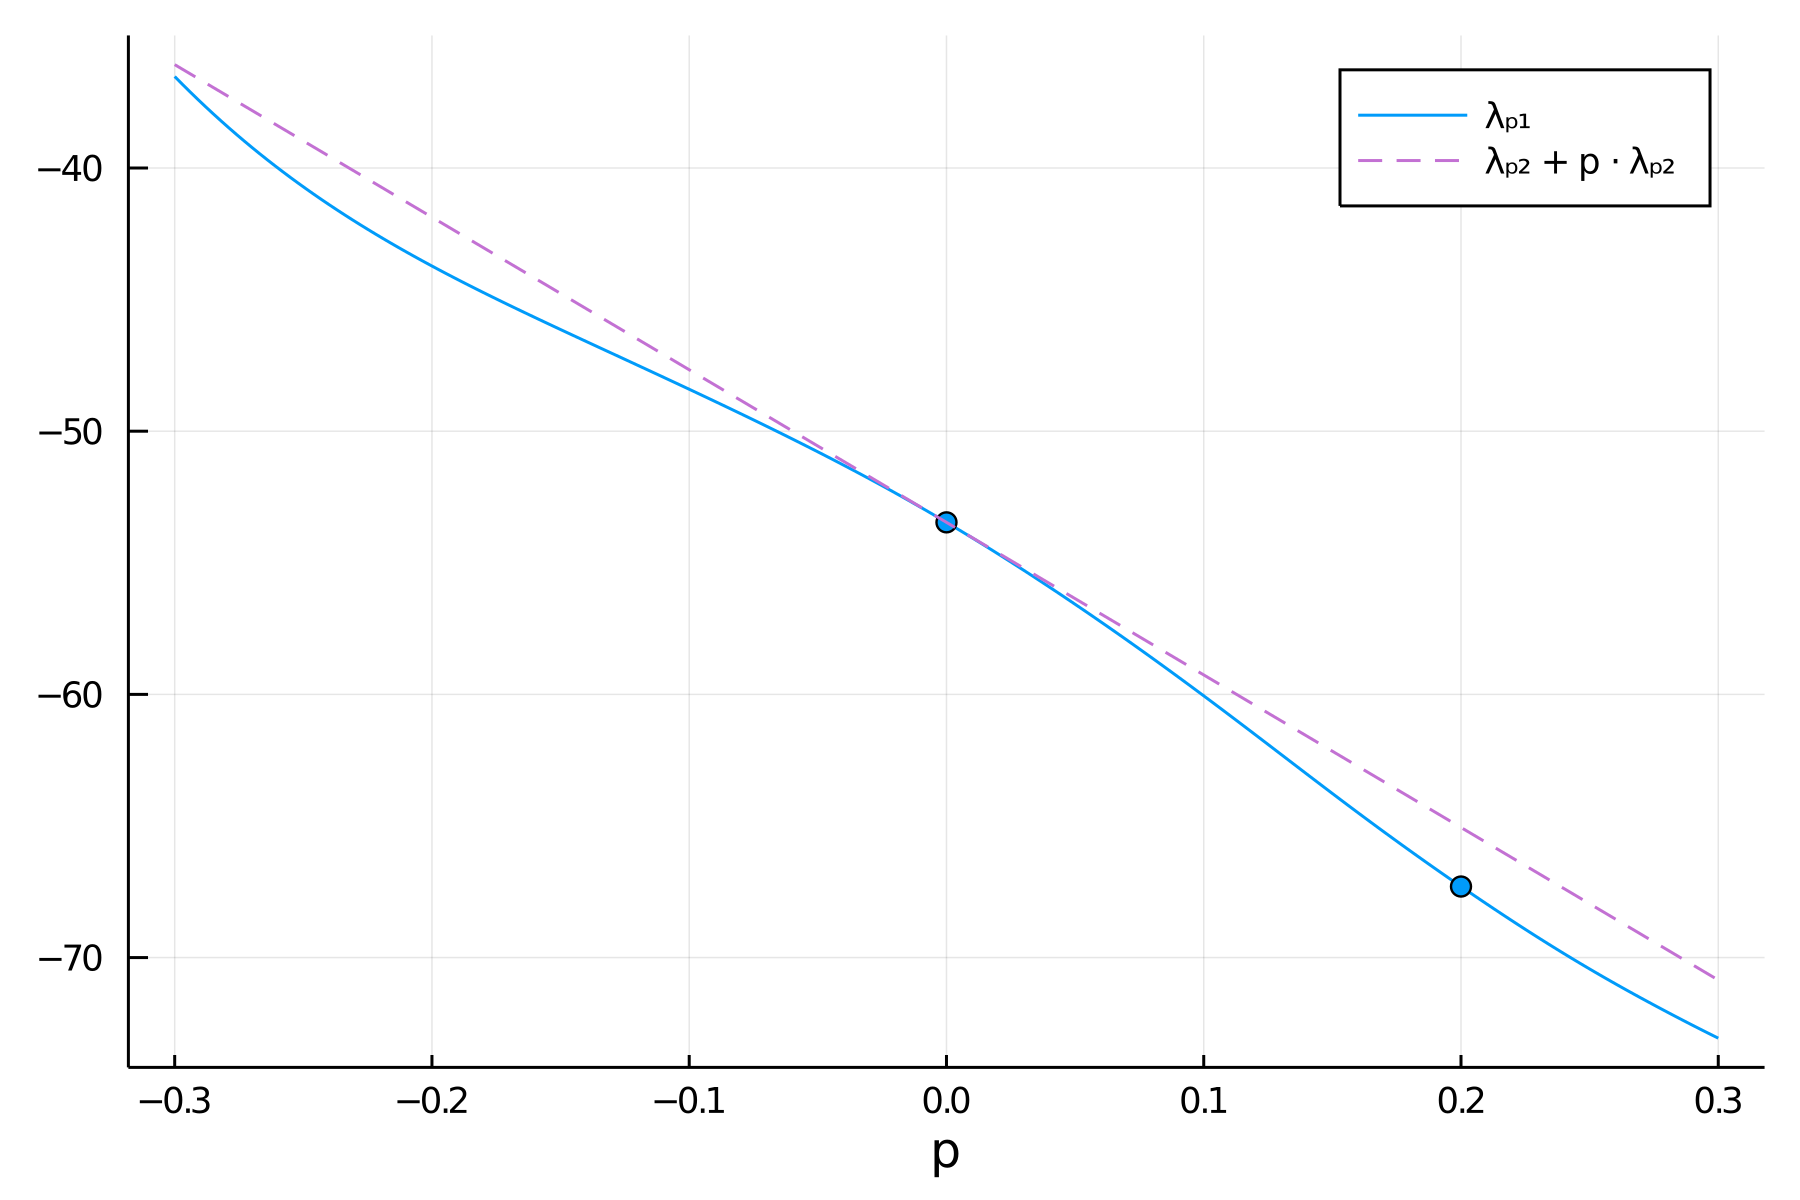

In [78]:
Plots.plot(file[:,1],file[:,3],label="λₚ₁")
Plots.scatter!([0],[λ₀[2]],color=1,label="")
Plots.scatter!([0.2],[λϵ[2]],color=1,label="")
Plots.plot!(file[:,1],file[:,1]*λ_dot[2] .+ λ₀[2],label="λₚ₂ + p ⋅ λₚ₂",style=:dash)
Plots.plot!(xlabel="p",fmt=:png,dpi=:300)